In [27]:
import pandas as pd 
import json 

# construct variable

## monthly growth in the nominal exchange rate

In [28]:
# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find the row index where "Exchange Rates, National Currency Per U.S. Dollar" appears
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates", na=False)].index[0]

# Extract the relevant row (France's exchange rate data)
exchange_rate_data = df.iloc[exchange_rate_row, 1:].reset_index(drop=True)

# Convert values to numeric (ignore the first value, which is text)
exchange_rate_data = pd.to_numeric(exchange_rate_data[1:], errors="coerce")

# Drop NaN values
exchange_rate_data.dropna(inplace=True)


In [93]:
# Compute the monthly growth rate in percentage
monthly_growth = exchange_rate_data.pct_change() * 100

# Convert to DataFrame for better visualization
monthly_growth_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth) + 1),
    "Growth (%)": monthly_growth.values
})

# Display the first few rows
display(monthly_growth_df.head())
monthly_growth_df.to_json('../Data/monthly_nominal_exchange_rate_growth.json', orient='records', indent=4)


,Month,Growth (%)
0,1,NaN
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


## Real exchange rate

In [30]:
import pandas as pd

# Load the dataset from an Excel file
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Dynamically locate row indices for relevant data
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate", na=False)].index[0]  # Row for nominal exchange rate (national currency per USD)
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]  # Row for France's CPI
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]  # Row for US CPI

# Extract numerical data from the identified rows
exchange_rate = pd.to_numeric(df.iloc[exchange_rate_row, 2:], errors="coerce")  # Nominal exchange rate (national currency per USD)
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")  # France's consumer price index
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")  # US consumer price index

# Drop NaN values to ensure data consistency (optional, depending on data quality)
exchange_rate.dropna(inplace=True)
france_cpi.dropna(inplace=True)
us_cpi.dropna(inplace=True)

# Compute Real Exchange Rate (RER) using the formula:
# RER = (Nominal Exchange Rate) * (US CPI / France CPI)
# Since the nominal exchange rate is in national currency per USD, this formula adjusts it for relative price levels.
rer = exchange_rate * (us_cpi / france_cpi)

# Compute the Monthly Growth Rate of the Real Exchange Rate (RER) using percentage change:
# Monthly Growth = (Current Month RER - Previous Month RER) / Previous Month RER * 100
monthly_growth_rer = rer.pct_change() * 100  # Convert to percentage

# Convert results into a DataFrame for better visualization
monthly_growth_rer_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth_rer) + 1),
    "Real Exchange Rate Growth (%)": monthly_growth_rer.values
})

# Display the first few rows of the computed RER growth
print(monthly_growth_rer_df.head())

# Save the computed RER growth data to a JSON file
monthly_growth_rer_df.to_json('../Data/monthly_real_exchange_rate_growth.json', orient='records', indent=4)


   Month  Real Exchange Rate Growth (%)
0      1                            NaN
1      2                      -1.642377
2      3                       0.110462
3      4                       0.000000
4      5                       0.186470


## An index of the real exchange rate (setting the real exchange rate for December 1990 = 1)

In [31]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Print the first few rows to inspect structure
print(df.head())

# Extract the date row (assuming it's the first row)
date_row = df.iloc[0, 2:].astype(str).str.strip()

# Print unique values to check format
display("\nRaw date row values:\n", date_row.unique())


                                        0    \
0  International Financial Statistics (IFS)   
1                                       NaN   
2                                    France   
3                                    France   
4                                    France   

                                                 1          2          3    \
0                                                NaN        NaN        NaN   
1                                                NaN   Dec 1959   Jan 1960   
2    Economic Activity, Industrial Production, Index  35.365725  33.997257   
3  Exchange Rates, National Currency Per U.S. Dol...    4.93706    4.93706   
4  International Reserves and Liquidity, Reserves...    1735.74    1753.74   

         4          5          6          7          8          9    \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1   Feb 1960   Mar 1960   Apr 1960   May 1960   Jun 1960   Jul 1960   
2  34.793828  34.916378  35.712949 

'\nRaw date row values:\n'

array(['nan'], dtype=object)

In [32]:
# Try parsing month-year format first
dates = pd.to_datetime(date_row, format="%b %Y", errors="coerce")

# Handle pure year values separately (if parsing failed)
dates.loc[dates.isna()] = pd.to_datetime(date_row.loc[dates.isna()], format="%Y", errors="coerce")

# Print parsed dates
print("\nParsed dates:\n", dates.dropna().unique())



Parsed dates:
 <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


In [33]:
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)  # Skip first row

print("Column Headers:", df.columns)


Column Headers: Index(['Unnamed: 0', 'Unnamed: 1', 'Dec 1959', 'Jan 1960', 'Feb 1960',
       'Mar 1960', 'Apr 1960', 'May 1960', 'Jun 1960', 'Jul 1960',
       ...
       'Mar 1990', 'Apr 1990', 'May 1990', 'Jun 1990', 'Jul 1990', 'Aug 1990',
       'Sep 1990', 'Oct 1990', 'Nov 1990', 'Dec 1990'],
      dtype='object', length=375)


In [34]:
# Identify columns that are four-digit years
year_only_columns = df.columns[2:][df.columns[2:].astype(str).str.match(r"^\d{4}$")]

# Drop these columns
df_cleaned = df.drop(columns=year_only_columns)

In [35]:
# Load data (skipping first row)
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)

# Extract only potential date columns (excluding the first two columns)
raw_date_headers = df.columns[2:]  # Ignore first two non-date columns

# Filter out standalone years (keep only "Month Year" format)
filtered_dates = [col for col in raw_date_headers if not col.isdigit()]  # Remove pure years

# Convert the filtered date headers to datetime
dates = pd.to_datetime(filtered_dates, format="%b %Y", errors="coerce")

# Debug: Check parsed dates
print("Parsed Dates:", dates)

# ✅ FIX: Remove .dt from DatetimeIndex
dec_1990_index = (dates.year == 1990) & (dates.month == 12)

if dec_1990_index.sum() == 0:
    raise ValueError(f"December 1990 not found! Check the parsed dates: {dates}")

print("December 1990 found at index:", dec_1990_index.argmax())


Parsed Dates: DatetimeIndex(['1959-12-01', '1960-01-01', '1960-02-01', '1960-03-01',
               '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01',
               '1960-08-01', '1960-09-01',
               ...
               '1990-03-01', '1990-04-01', '1990-05-01', '1990-06-01',
               '1990-07-01', '1990-08-01', '1990-09-01', '1990-10-01',
               '1990-11-01', '1990-12-01'],
              dtype='datetime64[ns]', length=373, freq=None)
December 1990 found at index: 372


In [36]:
# Extract the real exchange rate (RER) series
rer_series = rer.values  # Assuming `rer` is already computed

# Get RER value for December 1990
rer_dec_1990 = rer_series[372]

# Normalize the RER series to set Dec 1990 = 1
rer_index = rer_series / rer_dec_1990


In [37]:
rer_series = rer_series[:len(dates)]


In [38]:
print(f"Length of dates: {len(dates)}")
print(f"Length of rer_series: {len(rer_series)}")


Length of dates: 373
Length of rer_series: 373


In [39]:
rer_index_df = pd.DataFrame({
    "Date": dates,  
    "RER Index": rer_series
})


In [40]:
print(rer_index_df.head())
rer_index_df.to_json('../Data/real_exchange_rate_index.json', orient='records', indent=4)

        Date  RER Index
0 1959-12-01   6.520281
1 1960-01-01   6.413193
2 1960-02-01   6.420277
3 1960-03-01   6.420277
4 1960-04-01   6.432249


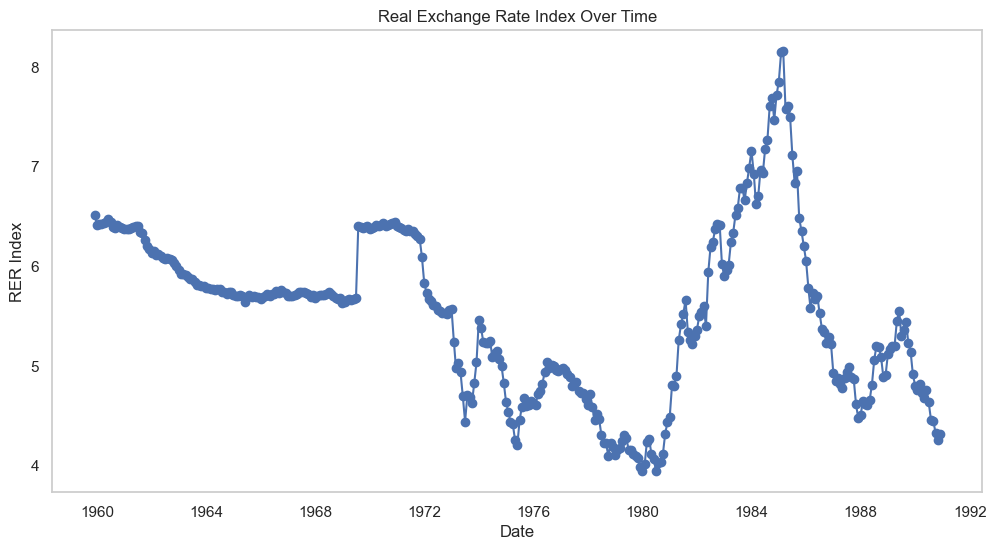

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(rer_index_df["Date"], rer_index_df["RER Index"], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("RER Index")
plt.title("Real Exchange Rate Index Over Time")
plt.grid()
plt.show()


## Monthly inflation rate

In [42]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US CPI dynamically
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract CPI data
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")

# Compute Monthly Inflation Rate (percentage change)
france_inflation = france_cpi.pct_change() * 100
us_inflation = us_cpi.pct_change() * 100

# Create DataFrame for visualization
inflation_df = pd.DataFrame({
    "Month": range(1, len(france_inflation) + 1),
    "France Inflation (%)": france_inflation.values,
    "US Inflation (%)": us_inflation.values
})

# Display first few rows
print(inflation_df)


inflation_df.to_json('../Data/Monthly_inflation.json', orient='records', indent=4)



     Month  France Inflation (%)  US Inflation (%)
0        1                   NaN               NaN
1        2              1.323986         -0.340136
2        3              0.230580          0.341297
3        4              0.000000          0.000000
4        5              0.153380          0.340136
5        6             -0.229708          0.000000
6        7             -0.076749          0.338983
7        8              0.384029          0.000000
8        9              0.918127          0.000000
9       10              0.151626          0.000000
10      11              0.151406          0.675676
11      12              0.302345          0.000000
12      13              0.226092          0.000000
13      14              0.075181          0.000000
14      15              0.075124          0.000000
15      16             -0.075068          0.000000
16      17             -0.075124          0.000000
17      18             -0.225582          0.000000
18      19             -0.22607

## The monthly growth in industrial production

In [43]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Monthly Growth in Industrial Production (percentage change)
france_ip_growth = france_ip.pct_change() * 100
us_ip_growth = us_ip.pct_change() * 100

# Create DataFrame for visualization
industrial_production_df = pd.DataFrame({
    "Month": range(1, len(france_ip_growth) + 1),
    "France IP Growth (%)": france_ip_growth.values,
    "US IP Growth (%)": us_ip_growth.values
})

# Display first few rows
print(industrial_production_df)


industrial_production_df.to_json('../Data/Montly_industrial_production.json', orient='records', indent=4)


     Month  France IP Growth (%)  US IP Growth (%)
0        1                   NaN               NaN
1        2             -3.869477          2.917232
2        3              2.343046          0.560316
3        4              0.352216         -0.229433
4        5              2.281369         -0.788436
5        6              0.085788         -0.231788
6        7              0.000000          0.232327
7        8             -7.628571         -6.026490
8        9            -26.848129          3.382664
9       10             43.128964          1.533742
10      11              5.878877          0.469956
11      12              3.376116         -3.575008
12      13             -0.323887         -4.365904
13      14             -3.384782          0.471014
14      15              1.933857          1.117923
15      16              1.182293          1.355207
16      17             -0.081522          2.533427
17      18              0.598314          1.509952
18      19              0.48661

## The growth in industrial production versus 12 months ago (i.e. January 1971 versus January 1970 etc.)


In [44]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Year-over-Year (YoY) Growth in Industrial Production
france_ip_yoy_growth = france_ip.pct_change(periods=12) * 100
us_ip_yoy_growth = us_ip.pct_change(periods=12) * 100

# Create DataFrame for visualization
industrial_production_yoy_df = pd.DataFrame({
    "Month": range(1, len(france_ip_yoy_growth) + 1),
    "France YoY IP Growth (%)": france_ip_yoy_growth.values,
    "US YoY IP Growth (%)": us_ip_yoy_growth.values
})

# Display first few rows
print(industrial_production_yoy_df)

industrial_production_yoy_df.to_json('../Data/YoY_growth.json', orient='records', indent=4)



     Month  France YoY IP Growth (%)  US YoY IP Growth (%)
0        1                       NaN                   NaN
1        2                       NaN                   NaN
2        3                       NaN                   NaN
3        4                       NaN                   NaN
4        5                       NaN                   NaN
5        6                       NaN                   NaN
6        7                       NaN                   NaN
7        8                       NaN                   NaN
8        9                       NaN                   NaN
9       10                       NaN                   NaN
10      11                       NaN                   NaN
11      12                       NaN                   NaN
12      13                  6.641640             -6.377205
13      14                  7.179333             -8.602505
14      15                  6.750807             -8.095706
15      16                  7.633811             -6.6360

## An index of the value of international reserves (value of reserves for January 1960 = 100)

In [45]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and U.S. International Reserves
france_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract International Reserves data
france_reserves = pd.to_numeric(df.iloc[france_reserves_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# Find the value of reserves in January 1960 (assumes the first column is Jan 1960)
jan_1960_index = 2  # Assuming the first data column corresponds to Jan 1960
france_reserves_jan_1960 = france_reserves.iloc[jan_1960_index]
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]

# Construct the Index (Normalize to Jan 1960 = 100)
france_reserves_index = (france_reserves / france_reserves_jan_1960) * 100
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
reserves_index_df = pd.DataFrame({
    "Month": range(1, len(france_reserves_index) + 1),
    "France Reserves Index": france_reserves_index.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(reserves_index_df)


     Month  France Reserves Index  US Reserves Index
0        1              96.604962         100.508513
1        2              97.606777         100.385124
2        3             100.000000         100.000000
3        4             104.064027          99.761634
4        5             108.406892          99.449889
5        6             116.699689          99.245643
6        7             114.529092          98.944180
7        8             114.584748          98.147759
8        9             120.706947          97.231687
9       10             121.374823          95.486476
10      11             122.823558          93.795482
11      12             126.334361          91.411826
12      13             126.446230          90.479863
13      14             130.787426          89.065560
14      15             135.907811          88.700066
15      16             145.259192          88.747739
16      17             150.212607          89.574541
17      18             157.838085          89.

# US

## Constructing monthly inflation rate and an index of the value of international reserves (value of reserves for January 1960 = 100)

In [46]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices dynamically
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract U.S. data
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# (i) Compute Monthly Inflation Rate
us_inflation_rate = us_cpi.pct_change() * 100  # Convert to percentage

# (ii) Compute International Reserves Index (Jan 1960 = 100)
jan_1960_index = 2  # Assuming first data column corresponds to Jan 1960
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
us_data_df = pd.DataFrame({
    "Month": range(1, len(us_cpi) + 1),
    "US Inflation Rate (%)": us_inflation_rate.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(us_data_df)


     Month  US Inflation Rate (%)  US Reserves Index
0        1                    NaN         100.508513
1        2              -0.340136         100.385124
2        3               0.341297         100.000000
3        4               0.000000          99.761634
4        5               0.340136          99.449889
5        6               0.000000          99.245643
6        7               0.338983          98.944180
7        8               0.000000          98.147759
8        9               0.000000          97.231687
9       10               0.000000          95.486476
10      11               0.675676          93.795482
11      12               0.000000          91.411826
12      13               0.000000          90.479863
13      14               0.000000          89.065560
14      15               0.000000          88.700066
15      16               0.000000          88.747739
16      17               0.000000          89.574541
17      18               0.000000          89.

# Identify outliers

In [47]:
from scipy.stats import zscore
import numpy as np

# Function to detect and set extreme outliers to NaN using a higher IQR multiplier
def detect_outliers(series, iqr_multiplier=10.0, z_threshold=10.0):  # More lenient thresholds
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    z_scores = np.abs(zscore(series, nan_policy='omit'))  # Compute Z-scores

    # Identify outliers based on both methods (looser thresholds)
    outliers = ((series < lower_bound) | (series > upper_bound)) | (z_scores > z_threshold)

    print(f"{series.name}: {outliers.sum()} outliers detected")  # Should be 0
    return series  # No values are masked

# Apply outlier detection with an extremely high threshold
exchange_rate_clean = detect_outliers(exchange_rate, iqr_multiplier=7.0, z_threshold=4.0)
us_inflation_rate_clean = detect_outliers(us_inflation_rate, iqr_multiplier=7.0, z_threshold=4.0)
industrial_production_growth_clean = detect_outliers(france_ip_yoy_growth, iqr_multiplier=7.0, z_threshold=4.0)
international_reserves_clean = detect_outliers(france_reserves_index, iqr_multiplier=7.0, z_threshold=4.0)
rer_growth_clean = detect_outliers(monthly_growth_rer, iqr_multiplier=7.0, z_threshold=4.0)

# Combine into cleaned DataFrame
cleaned_data = pd.DataFrame({
    "Exchange Rate": exchange_rate_clean,
    "US Inflation Rate (%)": us_inflation_rate_clean,
    "Industrial Production Growth (%)": industrial_production_growth_clean,
    "International Reserves Index": international_reserves_clean,
    "RER Growth (%)": rer_growth_clean
})

# Display summary statistics
print(cleaned_data.describe())


3: 0 outliers detected
9: 0 outliers detected
2: 3 outliers detected
4: 0 outliers detected
None: 2 outliers detected
       Exchange Rate  US Inflation Rate (%)  Industrial Production Growth (%)  \
count     373.000000             372.000000                        361.000000   
mean        5.485297               0.408794                          3.419042   
std         1.203652               0.351030                          6.062155   
min         4.004645              -0.457457                        -26.505263   
25%         4.937060               0.197343                          0.498146   
50%         4.937060               0.330579                          3.542234   
75%         5.736900               0.582275                          6.585736   
max        10.111500               1.805869                         63.276998   

       International Reserves Index  RER Growth (%)  
count                    373.000000      372.000000  
mean                    1539.572007       -0

In [48]:
# Function to fill missing values using mean of surrounding values
def fill_missing_values(series):
    return series.interpolate(method="linear")

# Now use it in your cleaned_data_filled
cleaned_data_filled = cleaned_data.copy()  # Make a copy to preserve original data

columns_to_fill = [
    "Exchange Rate",
    "US Inflation Rate (%)",
    "Industrial Production Growth (%)",
    "International Reserves Index",
    "RER Growth (%)"
]

for col in columns_to_fill:
    if col in cleaned_data_filled.columns:
        cleaned_data_filled[col] = fill_missing_values(cleaned_data_filled[col])
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Check if there are still missing values
print(cleaned_data_filled.isna().sum())


Exchange Rate                        0
US Inflation Rate (%)                1
Industrial Production Growth (%)    12
International Reserves Index         0
RER Growth (%)                       1
dtype: int64


# UH GG
# UH TRYING TO CONVERT ALL THE PREVIOUS DF INTO DATETIME & MERGE THEM INTO 1 SET

In [90]:
import pandas as pd

# List of DataFrames
dfs = {
    "monthly_growth_df": monthly_growth_df,
    "monthly_growth_rer_df": monthly_growth_rer_df,
    "rer_index_df": rer_index_df,
    "inflation_df": inflation_df,
    "industrial_production_df": industrial_production_df,
    "industrial_production_yoy_df": industrial_production_yoy_df,
    "reserves_index_df": reserves_index_df,
    "us_data_df": us_data_df
}

# Identify a reference DataFrame with a 'Date' column
reference_df = None
for name, df in dfs.items():
    if "Date" in df.columns:
        reference_df = df
        break

# Ensure a valid reference DataFrame is found
if reference_df is None:
    raise ValueError("No DataFrame with a 'Date' column found!")

# Get the earliest date from the reference DataFrame
start_date = reference_df["Date"].min()

# Convert DataFrames with 'Month' instead of 'Date'
for name, df in dfs.items():
    if "Month" in df.columns and "Date" not in df.columns:
        # Convert 'Month' to a Date format using start_date
        df["Date"] = pd.date_range(start=start_date, periods=len(df), freq="M")

# Standardize all Date formats and drop the 'Month' column if present
for name, df in dfs.items():
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])  # Ensure Date is in proper format
    if "Month" in df.columns:
        df.drop(columns=["Month"], inplace=True)  # Drop Month column to avoid conflicts

# Merge all DataFrames on 'Date' using an outer join
merged_df = reference_df.copy()
for name, df in dfs.items():
    if df is not reference_df:  # Ensure we're not merging the reference DF with itself
        merged_df = merged_df.merge(df, on="Date", how="outer")

# Show only the head of the merged DataFrame
display(merged_df.head())  # This will show the first 5 rows by default

# Optionally, save the merged dataset
merged_df.to_csv("../Data/full_merged_dataset.csv", index=False)
merged_df.to_json("../Data/full_merged_dataset.json", orient="records", indent=4)


,Growth (%),Date,Real Exchange Rate Growth (%),RER Index,France Inflation (%),US Inflation (%),France IP Growth (%),US IP Growth (%),France YoY IP Growth (%),US YoY IP Growth (%),France Reserves Index,US Reserves Index_x,US Inflation Rate (%),US Reserves Index_y
0,NaN,1959-12-01,NaN,6.520281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1959-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.604962,100.508513,NaN,100.508513
2,NaN,1960-01-01,NaN,6.413193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,1960-01-31,-1.642377,NaN,1.323986,-0.340136,-3.869477,2.917232,NaN,NaN,97.606777,100.385124,-0.340136,100.385124
4,NaN,1960-02-01,NaN,6.420277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question 5 
### Zhu Zhu - changes to question 4 to be made above, dont put anything of Q4 here

 For the graphs in 5.2, you should clearly indicate the time at which your country left the Bretton
 Woods system if it is sensible to do so and show the relevant data for every month from January 1960
 to December 1990

 5.2.1 Exchange Rate and International Reserve Graphs

 Plot the following time series graphs for your country versus the US dollar, presenting all the graphs
 together:

 • The monthly growth in the nominal exchange rate - used Ming's numbers

 • The level of the nominal exchange rate - im j taking raw nominal data idk what else it would be?

 • The monthly growth in the real exchange rate - Ming's data again

 • The real exchange rate index - thx Ming! note: weird date thing going on.....

In [50]:
import pandas as pd
import sqlite3
import json
import numpy as np
from lets_plot import *
LetsPlot.setup_html()
import datetime

In [51]:
df_graph_1 = pd.read_json('../Data/monthly_nominal_exchange_rate_growth.json')

# Display the first few rows
display(df_graph_1.head())

,Month,Growth (%)
0,1,NaN
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [52]:
df_graph_1['Growth (%)'] = pd.to_numeric(df_graph_1['Growth (%)'], errors='coerce')
df_graph_1 = df_graph_1.dropna(subset=['Growth (%)'])
df_graph_1['Growth (%)'].fillna(0, inplace=True)

a =   ggplot(df_graph_1, aes(x='Month', y='Growth (%)')) + \
        geom_line(color='blue', size=1) + \
        labs(title='Monthly Nominal Growth Over Time', x='Month', y='Growth (%)') + \
        ggsize(800, 400)

display(a)

C:\Users\Xueli\AppData\Local\Temp\ipykernel_7144\610503480.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_graph_1['Growth (%)'].fillna(0, inplace=True)


In [96]:
nominal_rate_df = pd.read_excel(file_path, header=1, engine="openpyxl")
nominal_rate_df.columns = nominal_rate_df.columns.astype(str)

# Select only relevant columns (not four-digit years) and filter for France Exchange Rates
monthly_cols = [x for x in nominal_rate_df.columns if not (x.strip().isdigit() and len(x.strip()) == 4)]
filtered_df = nominal_rate_df.loc[(nominal_rate_df.iloc[:, 0] == 'France') & 
                      (nominal_rate_df.iloc[:, 1].str.contains('Exchange Rates', na=False)), monthly_cols]

# Melt and reshape the data
df_graph_2 = pd.melt(filtered_df, id_vars=['Unnamed: 0', 'Unnamed: 1'], 
                    var_name='Date', value_name='Exchange Rate')[['Date', 'Exchange Rate']]

# Display the result
display(df_graph_2.head())

,Date,Exchange Rate


In [54]:
df_graph_2['Exchange Rate'] = pd.to_numeric(df_graph_2['Exchange Rate'], errors='coerce')
df_graph_2 = df_graph_2.dropna(subset=['Exchange Rate'])
df_graph_2['Exchange Rate'].fillna(0, inplace=True)

b =   ggplot(df_graph_2, aes(x='Date', y='Exchange Rate')) + \
        geom_line(color='red', size=1) + \
        labs(title='Monthly Nominal Exchange Rate Over Time', x='Date', y='Nominal Exchange Rate') + \
        ggsize(800, 400)

display(b)

C:\Users\Xueli\AppData\Local\Temp\ipykernel_7144\2198901466.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_graph_2['Exchange Rate'].fillna(0, inplace=True)


In [55]:
df_graph_3 = pd.read_json('../Data/monthly_real_exchange_rate_growth.json')

# Display the first few rows
display(df_graph_3.head())

,Month,Real Exchange Rate Growth (%)
0,1,NaN
1,2,-1.642377
2,3,0.110462
3,4,0.000000
4,5,0.186470


In [56]:
df_graph_3['Real Exchange Rate Growth (%)'] = pd.to_numeric(df_graph_3['Real Exchange Rate Growth (%)'], errors='coerce')
df_graph_3 = df_graph_3.dropna(subset=['Real Exchange Rate Growth (%)'])
df_graph_3['Real Exchange Rate Growth (%)'].fillna(0, inplace=True)

c =   ggplot(df_graph_3, aes(x='Month', y='Real Exchange Rate Growth (%)')) + \
        geom_line(color='Green', size=1) + \
        labs(title='Monthly Real Growth Over Time', x='Month', y='Real Exchange Rate Growth (%)') + \
        ggsize(800, 400)

display(c)

C:\Users\Xueli\AppData\Local\Temp\ipykernel_7144\4031717045.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_graph_3['Real Exchange Rate Growth (%)'].fillna(0, inplace=True)


In [57]:
df_graph_4 = pd.read_json('../Data/real_exchange_rate_index.json')

display(df_graph_4)

,Date,RER Index
0,-318297600000,6.520281
1,-315619200000,6.413193
2,-312940800000,6.420277
3,-310435200000,6.420277
4,-307756800000,6.432249
5,-305164800000,6.447059
6,-302486400000,6.473882
7,-299894400000,6.449115
8,-297216000000,6.390443
9,-294537600000,6.380768


In [58]:
df_graph_4['RER Index'] = pd.to_numeric(df_graph_4['RER Index'], errors='coerce')
df_graph_4 = df_graph_4.dropna(subset=['RER Index'])
df_graph_4['RER Index'].fillna(0, inplace=True)

d =   ggplot(df_graph_4, aes(x='Date', y='RER Index')) + \
        geom_line(color='Magenta', size=1) + \
        labs(title='Real Exchange Rate Index', x='Date', y='RER Index') + \
        ggsize(800, 400)

display(d)

C:\Users\Xueli\AppData\Local\Temp\ipykernel_7144\2703086610.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_graph_4['RER Index'].fillna(0, inplace=True)


In [59]:
gggrid([a, b, c, d], ncol=2) + ggsize(900, 600)

Putting all 4 graphs to one graph

In [60]:
df_graph_4['Date'] = pd.to_datetime(df_graph_4['Date'], unit='ms')

# Convert month numbers to datetime, assuming they start from Dec 1959
df_graph_1['Month'] = pd.to_numeric(df_graph_1['Month'], errors='coerce')

# Convert month numbers to datetime
start_date = pd.to_datetime('1959-12-01')
df_graph_1['Date'] = start_date + pd.to_timedelta((df_graph_1['Month'] - 1) * 30, unit='D')

df_graph_3['Month'] = pd.to_numeric(df_graph_3['Month'], errors='coerce')
df_graph_3['Date'] = start_date + pd.to_timedelta((df_graph_3['Month'] - 1) * 30, unit='D')

# Convert string dates to datetime for df_graph_2
df_graph_2['Date'] = pd.to_datetime(df_graph_2['Date'], format='%b %Y')

display(df_graph_4.tail())

,Date,RER Index
368,1990-08-01,4.456255
369,1990-09-01,4.448640
370,1990-10-01,4.326589
371,1990-11-01,4.254387
372,1990-12-01,4.313611


In [61]:
df_graph_1_2 = df_graph_1.drop(['Month'], errors='ignore')
df_graph_2_2 = df_graph_2.drop(['Date'], axis=1)
df_graph_3_2 = df_graph_3.drop(['Month'], errors='ignore')
df_graph_3_3 = df_graph_3_2.drop(['Date'], axis=1)
df_graph_4_2 = df_graph_4.drop(['Date'], axis=1)

# Ensure Date columns are in datetime format
df_graph_1_2['Date'] = pd.to_datetime(df_graph_1['Date'])

display(df_graph_3_3.tail())

,Month,Real Exchange Rate Growth (%)
368,369,-3.881317
369,370,-0.170874
370,371,-2.743558
371,372,-1.668805
372,373,1.392083


In [62]:
# Ensure Date columns are in datetime format
df_graph_1['Date'] = pd.to_datetime(df_graph_1['Date'])

combined_df = pd.concat([df_graph_4_2, df_graph_3_3, df_graph_2_2, df_graph_1_2], axis=1)

display(combined_df)

,RER Index,Month,Real Exchange Rate Growth (%),Exchange Rate,Month,Growth (%),Date
0,6.520281,NaN,NaN,4.937060,NaN,NaN,NaT
1,6.413193,2.0,-1.642377,4.937060,2.0,0.000000,1959-12-31
2,6.420277,3.0,0.110462,4.937060,3.0,0.000000,1960-01-30
3,6.420277,4.0,0.000000,4.937060,4.0,0.000000,1960-02-29
4,6.432249,5.0,0.186470,4.937060,5.0,0.000000,1960-03-30
5,6.447059,6.0,0.230236,4.937060,6.0,0.000000,1960-04-29
6,6.473882,7.0,0.416051,4.937060,7.0,0.000000,1960-05-29
7,6.449115,8.0,-0.382560,4.937060,8.0,0.000000,1960-06-28
8,6.390443,9.0,-0.909775,4.937060,9.0,0.000000,1960-07-28
9,6.380768,10.0,-0.151396,4.937060,10.0,0.000000,1960-08-27


In [63]:
melted_df = combined_df.melt(id_vars='Date', 
                               var_name='Metric', 
                               value_name='Value')

bretton_woods_end = pd.to_datetime('1971-08-01').timestamp() * 1000

p = ggplot(melted_df, aes(x='Date', y='Value', color='Metric')) + \
    geom_line() + \
    geom_vline(xintercept=bretton_woods_end, color='black', linetype='dashed', size=1) + \
    ggtitle('Combined Exchange Rate and Growth Metrics Over Time') + \
    scale_color_manual(values=['blue', 'red', 'green', 'magenta']) + \
    ggsize(900, 450)

p

## 5.2.2 Inflation and Industrial Production Graphs
 Plot the following time series graphs, presenting the inflation graphs together and the industrial production graphs together:

 • Monthly inflation.

 • The difference between monthly inflation in your country versus the US.

 • The monthly growth in industrial production.

 • The growth in industrial production versus 12 months ago.

 Why are your results for the monthly versus 12 monthly growth in industrial production so different?
 Which measure is more useful?

In [64]:
Monthly_inflation_graph_df = pd.read_json('../Data/Monthly_inflation.json')

display(Monthly_inflation_graph_df.head())


,Month,France Inflation (%),US Inflation (%)
0,1,NaN,NaN
1,2,1.323986,-0.340136
2,3,0.230580,0.341297
3,4,0.000000,0.000000
4,5,0.153380,0.340136


In [65]:
Monthly_inflation_graph_df['US-France Inflation Difference'] = Monthly_inflation_graph_df['France Inflation (%)'] - Monthly_inflation_graph_df['US Inflation (%)']

start_date = pd.to_datetime('1959-12-01')
Monthly_inflation_graph_df['Date'] = start_date + pd.to_timedelta((Monthly_inflation_graph_df['Month'] - 1) * 30, unit='D')

Monthly_inflation_graph_df_2 = Monthly_inflation_graph_df.drop(['Month'], axis=1)

display(Monthly_inflation_graph_df_2.head())

,France Inflation (%),US Inflation (%),US-France Inflation Difference,Date
0,NaN,NaN,NaN,1959-12-01
1,1.323986,-0.340136,1.664122,1959-12-31
2,0.230580,0.341297,-0.110717,1960-01-30
3,0.000000,0.000000,0.000000,1960-02-29
4,0.153380,0.340136,-0.186756,1960-03-30


In [66]:
Monthly_growth_graph_df = pd.read_json('../Data/Montly_industrial_production.json')

start_date = pd.to_datetime('1959-12-01')
Monthly_growth_graph_df['Date'] = start_date + pd.to_timedelta((Monthly_growth_graph_df['Month'] - 1) * 30, unit='D')

Monthly_inflation_graph_df_2 = Monthly_inflation_graph_df.drop(['Month'], axis=1)

Monthly_growth_graph_df_2 = Monthly_growth_graph_df.drop(['Month'], axis=1)

display(Monthly_growth_graph_df_2.head())

,France IP Growth (%),US IP Growth (%),Date
0,NaN,NaN,1959-12-01
1,-3.869477,2.917232,1959-12-31
2,2.343046,0.560316,1960-01-30
3,0.352216,-0.229433,1960-02-29
4,2.281369,-0.788436,1960-03-30


In [67]:
Growth_vs_12_months_df = pd.read_json('../Data/YoY_growth.json')

Growth_vs_12_months_df_2 = Growth_vs_12_months_df.drop(['Month'], axis=1)

display(Growth_vs_12_months_df_2.tail())

,France YoY IP Growth (%),US YoY IP Growth (%)
368,4.097257,1.915362
369,4.818828,2.506136
370,5.340079,1.768071
371,-0.058014,0.302552
372,-1.578180,-1.326504


In [68]:
combined_df = pd.concat([Growth_vs_12_months_df_2, Monthly_growth_graph_df_2], axis=1)

display(combined_df.head())

,France YoY IP Growth (%),US YoY IP Growth (%),France IP Growth (%),US IP Growth (%),Date
0,NaN,NaN,NaN,NaN,1959-12-01
1,NaN,NaN,-3.869477,2.917232,1959-12-31
2,NaN,NaN,2.343046,0.560316,1960-01-30
3,NaN,NaN,0.352216,-0.229433,1960-02-29
4,NaN,NaN,2.281369,-0.788436,1960-03-30


In [69]:
melted_df = combined_df.melt(id_vars='Date', 
                               var_name='Metric', 
                               value_name='Value')

bretton_woods_end = pd.to_datetime('1971-08-01').timestamp() * 1000

Industrial_Production_graphs = ggplot(melted_df, aes(x='Date', y='Value', color='Metric')) + \
    geom_line() + \
    geom_vline(xintercept=bretton_woods_end, color='black', linetype='dashed', size=1) + \
    ggtitle('Industrial Production data') + \
    scale_color_manual(values=['blue', 'red', 'green', 'magenta', 'black', 'pink', 'yellow']) + \
    ggsize(1200, 600)

Industrial_Production_graphs

In [70]:
melted_df_2 = Monthly_inflation_graph_df_2.melt(id_vars='Date', 
                               var_name='Metric', 
                               value_name='Value')

bretton_woods_end = pd.to_datetime('1971-08-01').timestamp() * 1000

Inflation_graphs = ggplot(melted_df_2, aes(x='Date', y='Value', color='Metric')) + \
    geom_line() + \
    geom_vline(xintercept=bretton_woods_end, color='black', linetype='dashed', size=1) + \
    ggtitle('Inflation Data') + \
    scale_color_manual(values=['blue', 'red', 'green', 'magenta', 'black', 'pink', 'yellow']) + \
    ggsize(1200, 600)

Inflation_graphs

# q6

In [71]:
# Load the dataset
file_path = "../Data/International_Financial_Statistics_ UK and Germany.xlsx"  # Update this with your actual file path
q6_data = pd.read_excel(file_path, header=None, engine="openpyxl")

q6_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,International Financial Statistics (IFS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Jan 1985,Feb 1985,Mar 1985,Apr 1985,May 1985,Jun 1985,Jul 1985,Aug 1985,Sep 1985,Oct 1985,Nov 1985,Dec 1985,Jan 1986,Feb 1986,Mar 1986,Apr 1986,May 1986,Jun 1986,Jul 1986,Aug 1986,Sep 1986,Oct 1986,Nov 1986,Dec 1986,Jan 1987,Feb 1987,Mar 1987,Apr 1987,May 1987,Jun 1987,Jul 1987,Aug 1987,Sep 1987,Oct 1987,Nov 1987,Dec 1987,Jan 1988,Feb 1988,Mar 1988,Apr 1988,May 1988,Jun 1988,Jul 1988,Aug 1988,Sep 1988,Oct 1988,Nov 1988,Dec 1988,Jan 1989,Feb 1989,Mar 1989,Apr 1989,May 1989,Jun 1989,Jul 1989,Aug 1989,Sep 1989,Oct 1989,Nov 1989,Dec 1989,Jan 1990,Feb 1990,Mar 1990,Apr 1990,May 1990,Jun 1990,Jul 1990,Aug 1990,Sep 1990,Oct 1990,Nov 1990,Dec 1990,Jan 1991,Feb 1991,Mar 1991,Apr 1991,May 1991,Jun 1991,Jul 1991,Aug 1991,Sep 1991,Oct 1991,Nov 1991,Dec 1991,Jan 1992,Feb 1992,Mar 1992,Apr 1992,May 1992,Jun 1992,Jul 1992,Aug 1992,Sep 1992,Oct 1992,Nov 1992,Dec 1992,Jan 1993,Feb 1993,Mar 1993,Apr 1993,May 1993,Jun 1993,Jul 1993,Aug 1993,Sep 1993,Oct 1993,Nov 1993,Dec 1993,Jan 1994,Feb 1994,Mar 1994,Apr 1994,May 1994,Jun 1994,Jul 1994,Aug 1994,Sep 1994,Oct 1994,Nov 1994,Dec 1994,Jan 1995,Feb 1995,Mar 1995,Apr 1995,May 1995,Jun 1995,Jul 1995,Aug 1995,Sep 1995,Oct 1995,Nov 1995,Dec 1995
2,Germany,"Economic Activity, Industrial Production, Index",67.413087,67.982143,74.482204,70.03395,69.39276,69.961816,68.759585,62.756446,73.14372,79.002591,77.030933,70.594991,69.256507,70.386604,75.33178,74.057416,69.817548,72.077742,70.170203,63.950662,74.41007,79.146859,76.109223,71.444567,67.629488,70.386604,76.109223,72.927319,71.797222,71.588835,68.406931,64.944506,74.906992,79.996436,77.808376,72.999452,69.681296,72.294144,79.074725,73.776895,72.791066,75.403914,69.464894,69.256507,78.649937,82.53715,80.982265,76.886665,74.129549,74.762724,81.903975,79.780034,73.985282,79.852168,74.698605,71.652954,81.976109,87.273939,84.733225,80.421224,78.369417,78.585818,87.129671,79.780034,81.2708,81.759707,78.794205,75.964955,86.496497,92.643903,89.461999,83.811515,83.034072,80.826837,84.820881,86.292371,79.670667,86.292371,81.983008,73.679601,84.820881,90.286415,87.028116,79.985986,81.247263,82.823859,89.235351,83.874923,79.145134,83.454498,79.56556,70.946834,86.187265,87.238329,83.664711,77.673645,69.160025,72.313217,84.505562,75.256197,71.787685,78.619602,70.421302,69.054918,81.457476,79.985986,80.931944,78.304283,70.000876,73.048962,85.031094,75.045984,76.097048,81.562582,72.418324,71.892791,84.085136,81.247263,85.031094,81.877901,74.730665,75.361303,87.763861,74.205133,81.247263,80.511518,73.99492,72.628536,82.403433,81.03705,85.766839,76.412368
3,Germany,"Exchange Rates, National Currency Per U.S. Dol...",3.1677,3.2921,3.3092,3.083,3.1139,3.0631,2.9168,2.79,2.8401,2.6444,2.5928,2.5145,2.4438,2.3314,2.2638,2.2745,2.2282,2.2365,2.1532,2.0636,2.0401,2.0047,2.0264,1.9916,1.8581,1.8265,1.8339,1.811,1.7863,1.8184,1.847,1.8581,1.8129,1.8021,1.6812,1.6332,1.6517,1.6976,1.678,1.6733,1.6934,1.7557,1.844,1.8874,1.8669,1.8215,1.7497,1.7555,1.8304,1.8521,1.8653,1.8704,1.9503,1.980

In [72]:
us_cpi_row1 = q6_data.iloc[8, 2:]
us_cpi_list = us_cpi_row1.tolist()

In [73]:
german_exchange_rate_row = q6_data.iloc[3, 2:]  # The exchange rates start from the 3rd column (index 2)
german_cpi_row = q6_data.iloc[4, 2:]

# Convert the exchange rates and cpi into a list
german_exchange_rate_list = german_exchange_rate_row.tolist()
german_cpi_list = german_cpi_row.tolist()

In [74]:
uk_exchange_rate_row = q6_data.iloc[6, 2:]  # The exchange rates start from the 3rd column (index 2)
uk_cpi_row = q6_data.iloc[7, 2:]

# Convert the exchange rates and cpi into a list
uk_exchange_rate_list = uk_exchange_rate_row.tolist()
uk_cpi_list = uk_cpi_row.tolist()

In [75]:
# finding the german real exchange rate
german_nominal = pd.Series(german_exchange_rate_list)
us_cpi_pandas = pd.Series(us_cpi_list)
german_cpi_pandas = pd.Series(german_cpi_list)
german_rer = german_nominal * (us_cpi_pandas / german_cpi_pandas)

In [76]:
# finding the uk real exchange rate
uk_nominal = pd.Series(uk_exchange_rate_list)
us_cpi_pandas = pd.Series(us_cpi_list)
uk_cpi_pandas = pd.Series(uk_cpi_list)
uk_rer = uk_nominal * (us_cpi_pandas / uk_cpi_pandas)

In [77]:
# gbp to gdm (german deutsche mark) exchange rate 
gbp_to_german = [gbp / eur for gbp, eur in zip(german_nominal, uk_nominal)]

In [78]:
# finding the date as a panda table 
date_row1 = q6_data.iloc[1, 2:]
date_list1 = date_row1.tolist()

In [79]:
gbp_to_gdm = pd.DataFrame({
    'Date': date_list1,
    'GBP_to_GDM': gbp_to_german
})

gbp_to_gdm

,Date,GBP_to_GDM
0,Jan 1985,3.576085
1,Feb 1985,3.607148
2,Mar 1985,3.697587
3,Apr 1985,3.828311
4,May 1985,3.888598
5,Jun 1985,3.923033
6,Jul 1985,4.016137
7,Aug 1985,3.864159
8,Sep 1985,3.870464
9,Oct 1985,3.762765


In [80]:
plot = ggplot(gbp_to_gdm) + \
    geom_line(aes(x='Date', y='GBP_to_GDM'), color='blue') + \
    labs(title="GBP to German Exchange Rate", x="Date", y="Exchange Rate") + \
    theme_minimal()

plot.show()

In [81]:
uk_rer_table = pd.DataFrame({
    'Date': date_list1,
    'uk_rer': uk_rer 

})

In [82]:
plot2 = ggplot(uk_rer_table) + \
    geom_line(aes(x='Date', y='uk_rer'), color='blue') + \
    labs(title="UK Real Exchange Rate", x="Date", y="Real Exchange Rate") + \
    theme_minimal()
plot2.show()

inflation difference (for point 3) and inflation of the uk (for point 4)

In [83]:
uk_inflation = uk_cpi_pandas.pct_change() * 100
uk_inflation_table = pd.DataFrame({
    'Date': date_list1,
    'uk_inflation': uk_inflation
})
uk_inflation_table

germany_inflation = german_cpi_pandas.pct_change() * 100
germany_inflation_table = pd.DataFrame({
    'Date': date_list1,
    'germany_inflation': germany_inflation

})

In [84]:
inflation_table = pd.merge(uk_inflation_table, germany_inflation_table, on='Date')

# Melt the DataFrame to have 'Source' as a categorical variable for coloring
inflation_table_melted = pd.melt(inflation_table, id_vars=["Date"], 
                                 value_vars=["uk_inflation", "germany_inflation"],
                                 var_name="Country", value_name="Inflation")

# Setup lets-plot for HTML rendering


# Create the plot
plot5 = ggplot(inflation_table_melted) + \
    geom_line(aes(x='Date', y='Inflation', color='Country'), size=1) + \
    labs(title="UK vs Germany Inflation", x="Date", y="Inflation (%)") + \
    theme_minimal() + \
    scale_color_manual(values={"uk_inflation": "red", "germany_inflation": "blue"})  # Set the colors for each country

# Display the plot
plot5.show()

In [85]:
uk_industrial_production_row = q6_data.iloc[5, 2:]
uk_industrial_production_list = uk_industrial_production_row.tolist()
uk_industrial_production_pandas =pd.Series(uk_industrial_production_list)
uk_ip_growth = uk_industrial_production_pandas.pct_change() * 100

germany_industrial_production_row = q6_data.iloc[2, 2:]
germany_industrial_production_list = germany_industrial_production_row.tolist()
germany_industrial_production_pandas = pd.Series(germany_industrial_production_list)
germany_ip_growth = germany_industrial_production_pandas.pct_change() * 100 

In [86]:
uk_ip_growth_table = pd.DataFrame({
    'Date': date_list1,
    'uk_ip_growth': uk_ip_growth
})

germany_ip_growth_table = pd.DataFrame({
    'Date': date_list1,
    'germany_ip_growth': germany_ip_growth
})

growth_table = pd.merge(germany_ip_growth_table, uk_ip_growth_table, on='Date')

In [87]:
# Melt the DataFrame to long format for ggplot
growth_table_melted = pd.melt(growth_table, id_vars=["Date"], 
                              value_vars=["uk_ip_growth", "germany_ip_growth"], 
                              var_name="Country", value_name="IP_Growth")

# Create the plot
plot = ggplot(growth_table_melted) + \
    geom_line(aes(x='Date', y='IP_Growth', color='Country'), size=1) + \
    labs(title="UK vs Germany Industrial Production Growth", x="Date", y="Industrial Production Growth (%)") + \
    theme_minimal() + \
    scale_color_manual(values={"uk_ip_growth": "red", "germany_ip_growth": "blue"})  # Set the colors for each country

# Display the plot
plot.show()